In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

In [5]:
bs=64 #or 16

In [7]:
folder = ['eurasian', 'arctic', 'ethiopian']

In [14]:
path = Path('data/wolves')
for i in folder:
    dest = path/i
    dest.mkdir(parents = True, exist_ok = True)

In [15]:
path.ls()

[WindowsPath('data/wolves/arctic'),
 WindowsPath('data/wolves/ethiopian'),
 WindowsPath('data/wolves/eurasian')]

In [16]:
for i in folder:
    print(i)
    verify_images(path/i, delete=True, max_size=500)

eurasian


arctic


ethiopian


In [17]:
np.random.seed(42)
# train = "." means training set is in current folder
data = ImageDataBunch.from_folder(path, train = ".", valid_pct = 0.2, ds_tfms = get_transforms(), 
                                  size = 224, num_workers = 4).normalize(imagenet_stats)
# num_workers is the number of CPUs to use

In [18]:
data.classes


['arctic', 'ethiopian', 'eurasian']

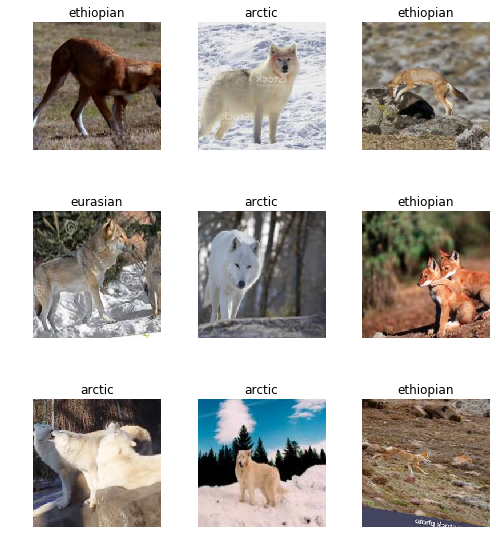

In [19]:
data.show_batch(rows=3, figsize=(7,8))

In [22]:
data.c, len(data.train_ds), len(data.valid_ds)

(3, 478, 119)

##Training

In [23]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

In [24]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.181089,0.134320,0.033613,02:14
1,0.662749,0.236355,0.050420,02:37
2,0.488186,0.302813,0.058824,02:29
3,0.382042,0.288668,0.042017,02:35


In [25]:
learn.save('stage-1')

In [27]:
learn.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


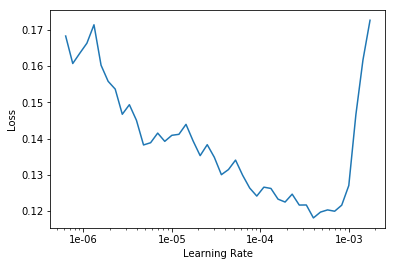

In [28]:
learn.lr_find()
learn.recorder.plot()

The validation loss is NaN because we don’t track its value. Here we want to find an optimal lr value for the training of our model and thus we check its training loss

In [29]:
learn.fit_one_cycle(4, max_lr=slice(3e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.144449,0.260752,0.042017,04:09
1,0.124227,0.232455,0.042017,04:04
2,0.117015,0.227073,0.042017,41:16
3,0.119805,0.222373,0.042017,02:26


In [30]:
learn.save('stage-2')

Interpretation

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
# losses, idxs = interp.top_losses()
# len(data.valid_ds)==len(losses)==len(idxs)

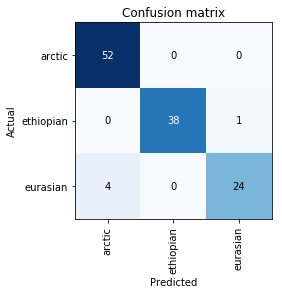

In [32]:
interp.plot_confusion_matrix()

Cleaning up(removing noisy images)

In [37]:
from fastai.widgets import *
# losses, idxs = interp.top_losses()
# top_loss_paths = data.valid_ds.x[idxs] 

In [ ]:
# fd = FileDeleter(file_paths=top_loss_paths)

In [34]:
db = (ImageList.from_folder(path)
      .split_none()
      .label_from_folder()
      .transform(get_transforms(), size =224)
      .databunch()
     )

In [56]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   #.split_none()
                   .split_by_rand_pct() # when training the model
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [68]:
learn_cln = cnn_learner(db, models.resnet34, metrics = error_rate)
learn_cln.load('stage-2') #loading parameters/weights that we previously calculated
# so that we can improve upton them

Learner(data=ImageDataBunch;

Train: LabelList (460 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
arctic,arctic,arctic,arctic,arctic
Path: data\wolves;

Valid: LabelList (115 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ethiopian,ethiopian,ethiopian,ethiopian,ethiopian
Path: data\wolves;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [69]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
ds

LabelList (460 items)
x: ImageList
Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
y: CategoryList
arctic,arctic,arctic,arctic,arctic
Path: data\wolves

In [39]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [43]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [44]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [70]:
learn_cln.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.103867,0.400670,0.121739,05:24
1,0.082792,0.159620,0.052174,05:24
2,0.085046,0.125321,0.043478,05:24
3,0.079402,0.106537,0.043478,05:27


In [71]:
learn_cln.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


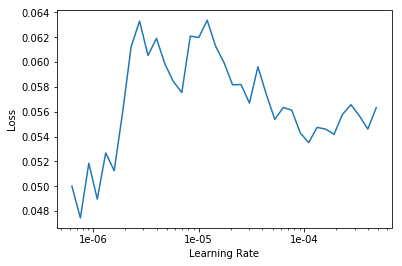

In [72]:
learn_cln.lr_find()
learn_cln.recorder.plot()

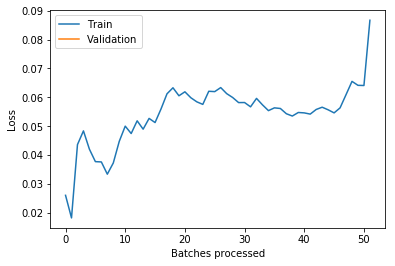

In [73]:
learn_cln.recorder.plot_losses()

In [63]:
learn_cln.fit_one_cycle(4, max_lr=slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.127503,0.107640,0.034783,03:10
1,0.080402,0.127544,0.043478,03:53
2,0.080533,0.124732,0.052174,03:24
3,0.070104,0.104798,0.052174,03:15


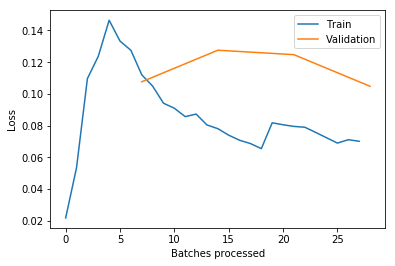

In [65]:
learn_cln.recorder.plot_losses()

In [66]:
learn_cln.fit_one_cycle(10, max_lr=slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.038280,0.098069,0.060870,03:00
1,0.034953,0.094743,0.026087,03:12
2,0.038102,0.093686,0.017391,03:10
3,0.033164,0.098806,0.026087,03:14
4,0.028189,0.132771,0.034783,03:08
5,0.030913,0.161656,0.043478,03:10
6,0.028764,0.158198,0.043478,03:08
7,0.025194,0.164162,0.043478,03:13
8,0.023477,0.159950,0.043478,03:08
9,0.022045,0.178784,0.043478,03:07


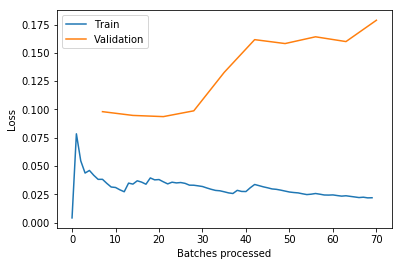

In [67]:
learn_cln.recorder.plot_losses()

Putting model in production

In [74]:
learn_cln.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [45]:
defaults.device = torch.device('cpu')

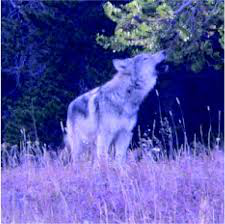

In [52]:
img = open_image(path/'eurasian'/'images (33).jpg')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [53]:
learn = load_learner(path)

In [54]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category eurasian